In [ ]:
import pandas as pd

# Load the dataset with error handling
data = pd.read_csv('/content/IMDB Dataset.csv', on_bad_lines='skip', encoding='utf-8')

# Display the first few rows of the dataset
print(data.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# Check for missing values in the dataset
print("Missing values per column:")
print(data.isnull().sum())


Missing values per column:
review       0
sentiment    0
dtype: int64


In [ ]:
import re

# Function to clean the review text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the cleaning function to the review column
data['review'] = data['review'].apply(clean_text)

# Display the first few cleaned reviews
print(data['review'].head())


0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object


In [ ]:
import re

# Define a custom list of stopwords
custom_stopwords = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
    'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
    'just', 'don', 'should', 'now'
])

# Function for cleaning, tokenization, and stopword removal
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize using split() and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_stopwords]
    return ' '.join(tokens)

# Apply the function to preprocess the text
data['review'] = data['review'].apply(preprocess_text)

# Display the first few preprocessed reviews
print(data['review'].head())


0    one reviewers mentioned watching oz episode yo...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically theres family little boy jake thinks...
4    petter matteis love time money visually stunni...
Name: review, dtype: object


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data['review'],  # Features (reviews)
    data['sentiment'],  # Labels (sentiment)
    test_size=0.2,  # 20% for testing
    random_state=42  # For reproducibility
)

# Display the sizes of the splits
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Training set size: 40000
Testing set size: 10000


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for simplicity
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit and transform the training data
X_test_tfidf = vectorizer.transform(X_test)  # Transform the testing data

# Train a Naive Bayes classifier
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model_nb.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4961
    positive       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for tokenization
vocab_size = 5000  # Maximum number of words to keep
max_length = 200  # Maximum review length in words
embedding_dim = 128  # Embedding dimension

# Tokenize the text
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Display the shape of the padded data
print("Padded training data shape:", X_train_padded.shape)
print("Padded testing data shape:", X_test_padded.shape)


Padded training data shape: (40000, 200)
Padded testing data shape: (10000, 200)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the LSTM model
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=200),  # Embedding layer
    LSTM(128, return_sequences=True),  # LSTM layer with 128 units
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(64),  # Another LSTM layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model_lstm.summary()

from sklearn.preprocessing import LabelEncoder

# Encode the sentiment labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert to 0s and 1s
y_test_encoded = label_encoder.transform(y_test)

# Confirm the encoding
print("Encoded labels example:", y_train_encoded[:5])

history = model_lstm.fit(
    X_train_padded, y_train_encoded,  # Use encoded labels
    epochs=5,
    batch_size=32,
    validation_split=0.2
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Encoded labels example: [0 0 1 0 0]
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 517s 514ms/step - accuracy: 0.4991 - loss: 0.6937 - val_accuracy: 0.5175 - val_loss: 0.6916
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 568s 520ms/step - accuracy: 0.5252 - loss: 0.6873 - val_accuracy: 0.5297 - val_loss: 0.6818
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 557s 515ms/step - accuracy: 0.7515 - loss: 0.4989 - val_accuracy: 0.8649 - val_loss: 0.3170
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 560s 513ms/step - accuracy: 0.8998 - loss: 0.2579 - val_accuracy: 0.8704 - val_loss: 0.3059
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 564s 515ms/step - accuracy: 0.9202 - loss: 0.2069 - val_accuracy: 0.8731 - val_loss: 0.3081


In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = (model_lstm.predict(X_test_padded) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test_encoded, y_pred))


Test Accuracy: 0.8776
Test Loss: 0.2964
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



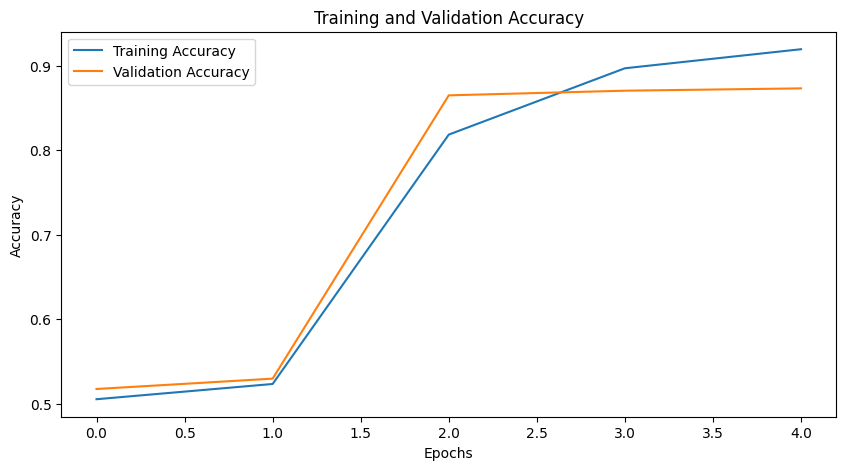

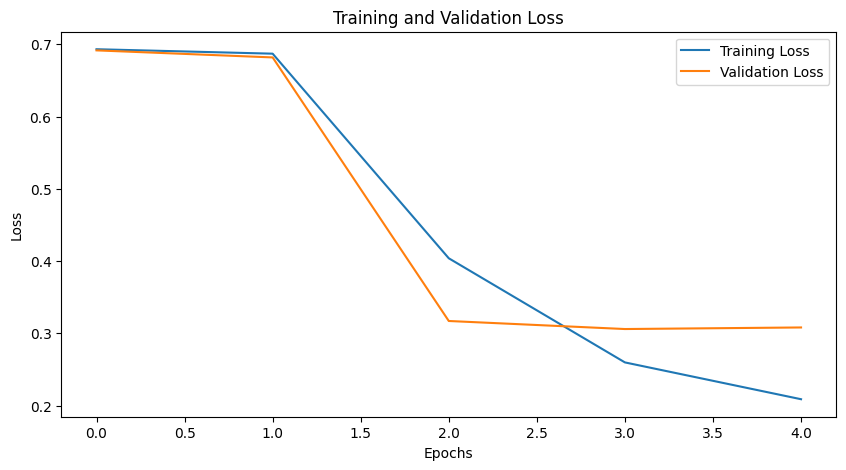

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


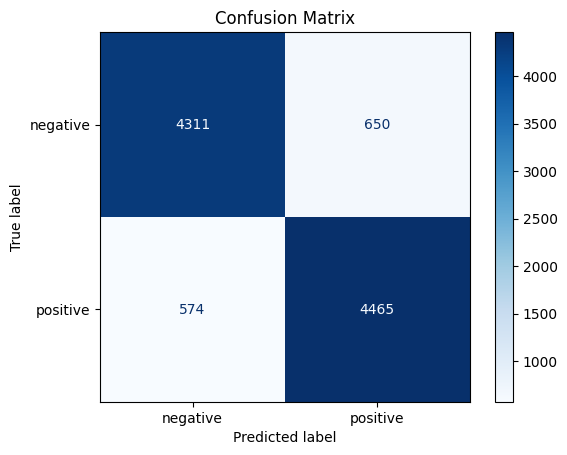

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step


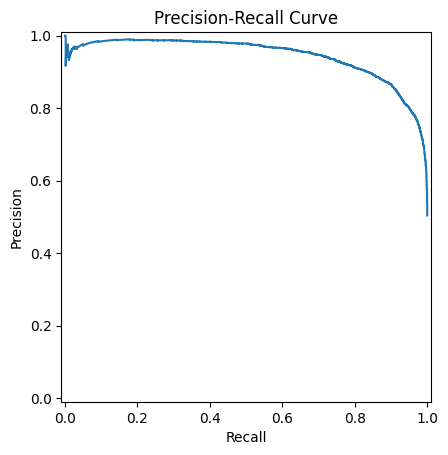

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Generate precision-recall values
precision, recall, _ = precision_recall_curve(y_test_encoded, model_lstm.predict(X_test_padded))

# Visualize the precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title('Precision-Recall Curve')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 155ms/step


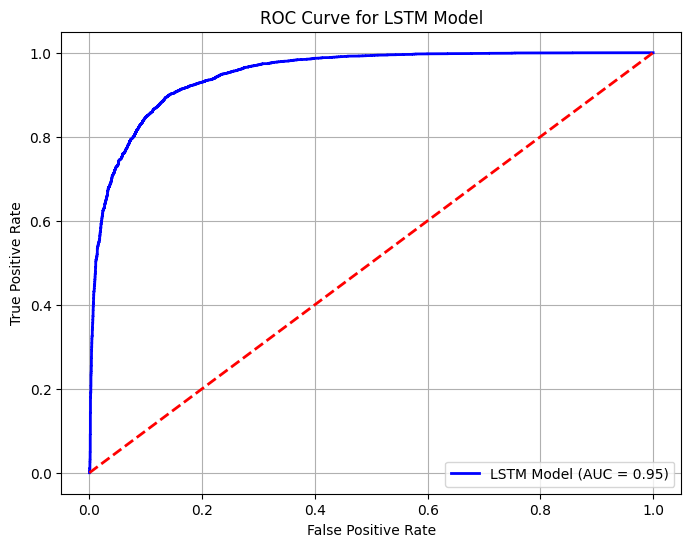

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for LSTM model
fpr, tpr, _ = roc_curve(y_test_encoded, model_lstm.predict(X_test_padded).ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"LSTM Model (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LSTM Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()


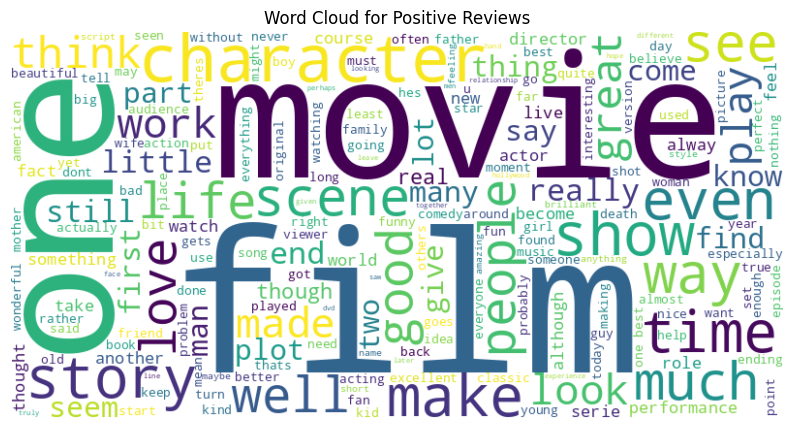

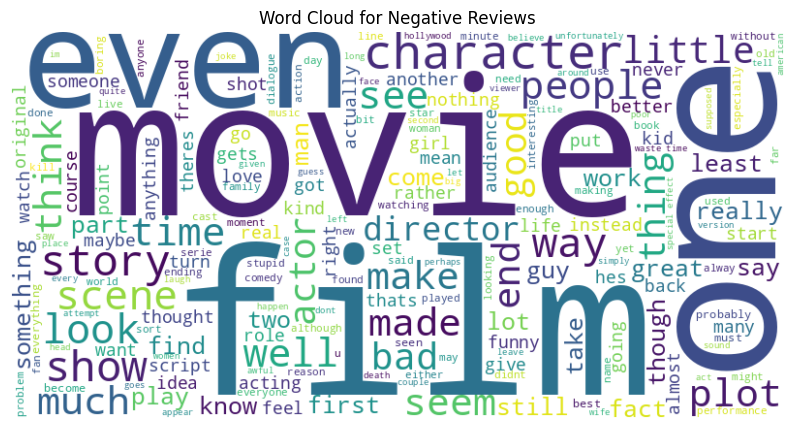

In [ ]:
from wordcloud import WordCloud

# Generate word clouds for positive and negative reviews
positive_reviews = " ".join(data[data['sentiment'] == 'positive']['review'])
negative_reviews = " ".join(data[data['sentiment'] == 'negative']['review'])

# Positive reviews word cloud
plt.figure(figsize=(10, 8))
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_reviews)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

# Negative reviews word cloud
plt.figure(figsize=(10, 8))
wordcloud_neg = WordCloud(width=800, height=400, background_color="white").generate(negative_reviews)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Reviews")
plt.show()


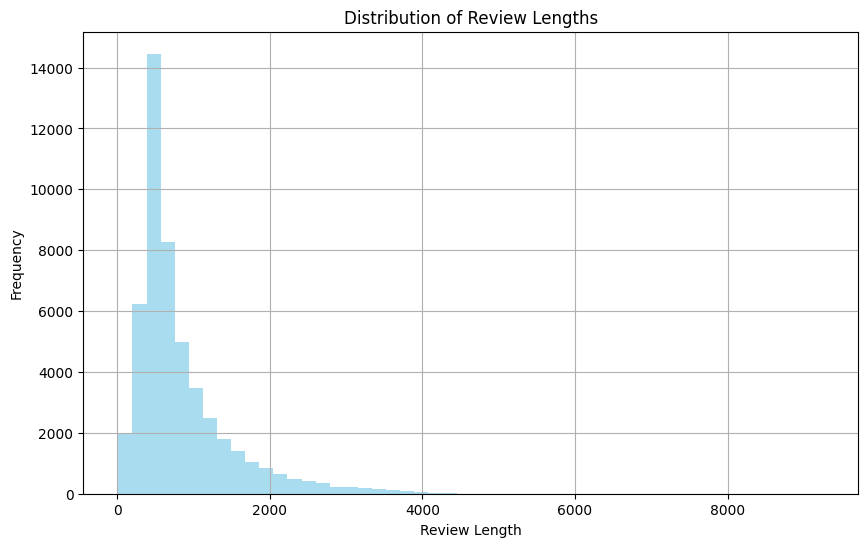

In [ ]:
# Calculate review lengths
data['review_length'] = data['review'].apply(len)

# Plot distribution of review lengths
plt.figure(figsize=(10, 6))
plt.hist(data['review_length'], bins=50, color='skyblue', alpha=0.7)
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.grid()
plt.show()


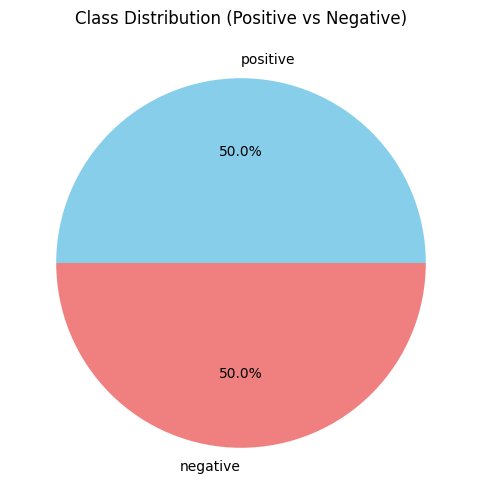

In [ ]:
# Plot class distribution
plt.figure(figsize=(6, 6))
data['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.ylabel("")
plt.title("Class Distribution (Positive vs Negative)")
plt.show()
